# SDG&E Test System Data

This notebook is used to preprocess the data needed to create the San Diego test system model

In [1]:
import pandas as pd
import geopandas as gpd
import scipy.io 
import os
from os.path import join
import pylab as plt

# Path to each of the datasets
PATH = join(os.getcwd(), '..', 'data')
CATS = 'cats'
OPF = 'opf'

In [3]:
def read_csv(filename, subdir=CATS):
    df = pd.read_csv(join(PATH, subdir, filename))
    df = standardize(df)
    return df

def read_geocsv(filename):
    '''
    Read a dataset with Lat and Lon columns and 
    return a geopandas DataFrame with point geometries
    '''
    df = read_csv(filename)
    gdf = gpd.GeoDataFrame(df,
           geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
    return gdf

def read_mat(filename, columns, subdir=OPF):
    '''
    Read a MATLAB .mat file of a matrix 
    and return dataframe where each columns is labeled
    '''
    # Assume object has the same name as the file
    object_name = filename.split(".")[0]
    
    # Read data and place in dataframe
    path = join(PATH, subdir, filename)
    data = scipy.io.loadmat(path)[object_name]
    df = pd.DataFrame(data=data, columns=columns)
    df = standardize(df)
    return df

def standardize(df):
    # Adjust index to start at 1 not 0
    df.index += 1
    # Make all columns lowercase
    df.columns = [s.lower() for s in df.columns]
    return df

In [39]:
# Read each of the CATS datasets
buses = read_geocsv('buses.csv').rename(columns={'bus_i':'bus'})
gens = read_csv('generators.csv')
gens['id'] = gens.index # Add an index to generators

lines = (gpd
         .read_file(join(PATH, CATS, 'lines.json'))
         .pipe(standardize)
         .rename(columns={'cats_id':'id', 'br_r':'r', 'br_x':'x', 'br_b':'b'})
        )
lines = lines[~lines['transformer']] # Drop transformers from dataset

loads = read_csv('loads.csv').rename(columns={'bus_i':'bus'}).set_index('bus')

# Read OPF datasets (in base of 100MVA)
columns = ['model', 'startup', 'shutdown', 'n', 'c2', 'c1', 'c0']
gencost = read_mat('gencost.mat', columns)
# Add generator costs to the gens dataset
gens = gencost.join(gens)

# Read IOU shapefile and select SDG&E shape
ious = gpd.read_file(join(PATH, 'iou.geojson'))
sdge = ious[ious['Acronym'] == 'SDG&E'][['geometry']]

In [50]:
# Select all buses in SDG&E service area (to create a test system)
sd_buses = gpd.sjoin(buses, sdge).drop(columns='index_right')
bus_ids = list(sd_buses.index)

### Select all gens, lines, and loads in SDG&E area ###
# Select generators (and only relevant columns)
cols = ['id', 'bus', 'startup', 'shutdown', 'n', 'c2', 'c1', 'c0',  
        'fueltype', 'pg', 'pmax', 'pmin', 'qg', 'qmax', 'qmin']
sd_gens = gens[gens['bus'].isin(bus_ids)]
sd_gens = sd_gens[cols].reset_index(drop=True)

# Select lines (only that start and end in SDG&E area)
cols = ['id', 'f_bus', 't_bus', 'r', 'x', 'b', 'rate_a', 'kv', 'geometry']
sd_lines = lines[(lines['f_bus'].isin(bus_ids) & lines['t_bus'].isin(bus_ids))]
sd_lines = sd_lines[cols]
# Add lines in the reverse direction
cpy = sd_lines.copy()
cpy['f_bus'], cpy['t_bus'] = cpy['t_bus'], cpy['f_bus']
sd_lines = pd.concat((sd_lines, cpy)).reset_index(drop=True)

# Select loads
sd_loads = loads[loads.index.isin(bus_ids)]
# Select 24 hours of load from a representative week in each season
# Representative weeks are determined using k-means clustering on all load profiles
load_24h_sp = sd_loads.loc[:, slice("2018-04-02T01:00:00", "2018-04-03T01:00:00")]
load_24h_su = sd_loads.loc[:, slice("2018-08-11T01:00:00", "2018-08-12T01:00:00")]
load_24h_fa = sd_loads.loc[:, slice("2018-10-22T01:00:00", "2018-10-23T01:00:00")]
load_24h_wi = sd_loads.loc[:, slice("2018-12-07T01:00:00", "2018-12-08T01:00:00")]

In [54]:
# Save each of the San Deigo test system files in data directory 
sd_buses.to_csv(join(PATH, "test_system", "buses.csv"))
sd_gens.to_csv(join(PATH, "test_system", "gens.csv"))
sd_lines.to_csv(join(PATH, "test_system", "lines.csv"))

# And each of the four 24h load profiles
load_24h_sp.to_csv(join(PATH, "test_system", "loads_24h_sp.csv"))
load_24h_su.to_csv(join(PATH, "test_system", "loads_24h_su.csv"))
load_24h_fa.to_csv(join(PATH, "test_system", "loads_24h_fa.csv"))
load_24h_wi.to_csv(join(PATH, "test_system", "loads_24h_wi.csv"))

<Axes: >

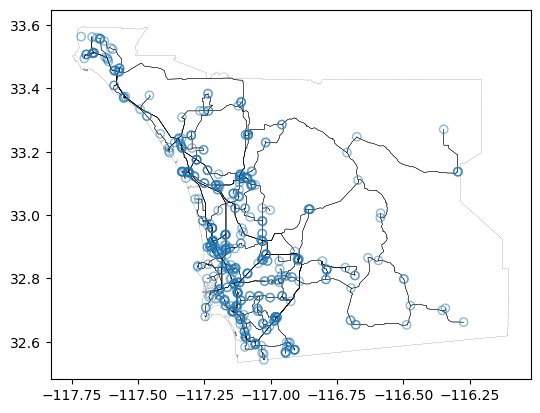

In [46]:
fig, ax = plt.subplots()
sd_lines.plot(ax=ax, color='k', lw=0.3)
sd_buses.plot(ax=ax, zorder=2, alpha=0.5, facecolor='none', edgecolor='C0')
sdge.plot(ax=ax, facecolor='none', edgecolor='k', lw = 0.1)

In [52]:
sd_lines

,id,f_bus,t_bus,r,x,b,rate_a,kv,geometry
0,5059,7986,5746,0.000929,0.002456,0.000037,0.64,66.0,"LINESTRING (-117.64 33.556, -117.64 33.558, -1..."
1,6809,5753,5746,0.001212,0.003071,0.000051,0.64,66.0,"LINESTRING (-117.65 33.558, -117.64 33.558, -1..."
2,6810,5752,5753,0.003327,0.007609,0.000156,0.64,66.0,"LINESTRING (-117.65 33.56, -117.65 33.559, -11..."
3,8401,8309,7006,0.000436,0.004820,0.011155,10.56,230.0,"LINESTRING (-117.55 33.37, -117.55 33.372, -11..."
4,8403,8309,7985,0.000804,0.010888,0.022423,11.58,230.0,"LINESTRING (-117.55 33.37, -117.55 33.372, -11..."
...,...,...,...,...,...,...,...,...,...
1093,8951,7044,7656,0.002265,0.015365,0.027976,3.66,230.0,"LINESTRING (-117.03 32.918, -117.03 32.919, -1..."
1094,8952,7046,7045,0.000100,0.000260,0.000030,1.18,115.0,"LINESTRING (-117.57 33.464, -117.57 33.464)"
1095,8953,1079,8823,0.040330,0.077235,0.001017,0.41,66.0,"LINESTRING (-117.59 33.409, -117.59 33.409, -1..."
1096,8954,7620,8040,0.000198,0.002391,0.010461,8.71,230.0,"LINESTRING (-116.68 32.809, -116.68 32.812, -1..."
